# COMS4030 - Adaptive Computation and Machine Learning Project
# Person Detection using Histograms of Oriented Gradients and a Linear SVM
# Nishai Kooverjee (1354477)

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.feature import hog
from cvxopt import matrix, solvers
import pandas as pd
import h5py
from os import listdir
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from bokeh.plotting import figure
from bokeh.io import output_notebook, show, push_notebook
import time

## Preliminary stuff
### Image samples

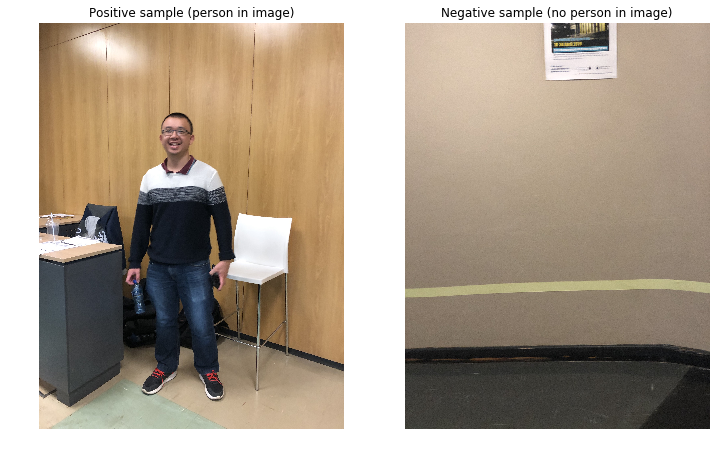

In [106]:
jiahao = cv2.imread('images/jiahao.jpeg')
jiahao = cv2.cvtColor(jiahao, cv2.COLOR_BGR2RGB)
jiahao = np.float32(jiahao) / 255.0

wall = cv2.imread('images/wall.jpeg')
wall = cv2.cvtColor(wall, cv2.COLOR_BGR2RGB)
wall = np.float32(wall) / 255.0

plt.figure(figsize=(12,9))
plt.subplot(1,2,1)
plt.axis('off')
plt.title('Positive sample (person in image)')
plt.imshow(jiahao)
plt.subplot(1,2,2)
plt.axis('off')
plt.title('Negative sample (no person in image)')
plt.imshow(wall)

### Combined horizontal and vertical Sobel filter

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


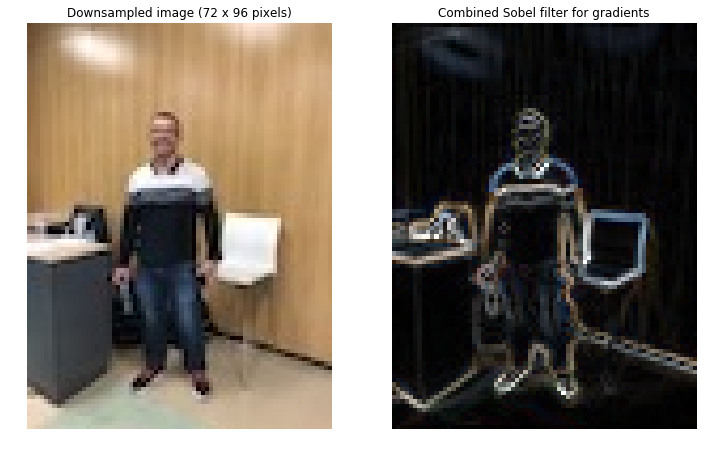

In [51]:
jiahao = cv2.imread('images/pos/pos_1.jpeg')
jiahao = cv2.cvtColor(jiahao, cv2.COLOR_BGR2RGB)
jiahao = np.float32(jiahao) / 255.0

gx = cv2.Sobel(jiahao, cv2.CV_32F, 1, 0, ksize=1)
gy = cv2.Sobel(jiahao, cv2.CV_32F, 0, 1, ksize=1)

mag, angle = cv2.cartToPolar(gx, gy, angleInDegrees=True)

plt.figure(figsize=(12,9))
plt.subplot(1,2,1)
plt.axis('off')
plt.title('Downsampled image (72 x 96 pixels)')
plt.imshow(jiahao)
plt.subplot(1,2,2)
plt.axis('off')
plt.title('Combined Sobel filter for gradients')
plt.imshow(mag)

### Histogram of Oriented Gradients

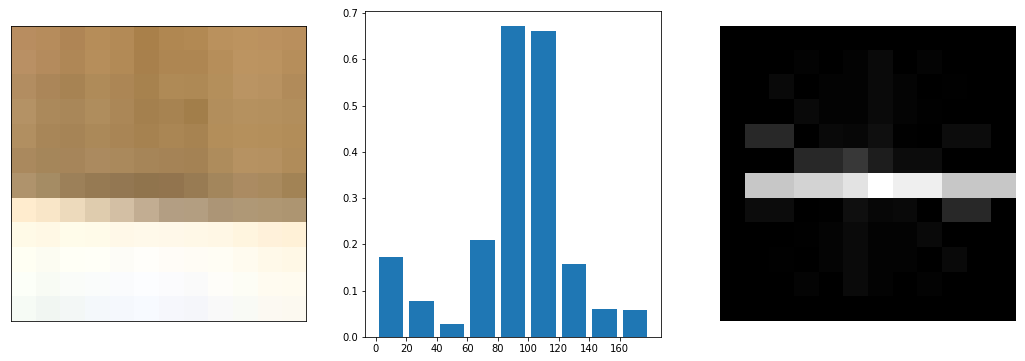

In [52]:
tile = cv2.imread('images/tile.jpeg')
tile = cv2.cvtColor(tile, cv2.COLOR_BGR2RGB)
tile = np.float32(tile) / 255.0

f_tile, h_tile = hog(tile, orientations=9, pixels_per_cell=(12, 12), cells_per_block=(1, 1), visualize=True, block_norm='L2-Hys')

plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
plt.xticks([])
plt.yticks([])
plt.imshow(tile)
plt.subplot(1,3,2)
plt.bar(np.arange(9), f_tile)
plt.xticks(np.arange(9)-0.5, np.arange(9)*20)
plt.subplot(1,3,3)
plt.axis('off')
plt.imshow(h_tile, cmap='gray')

(864,)

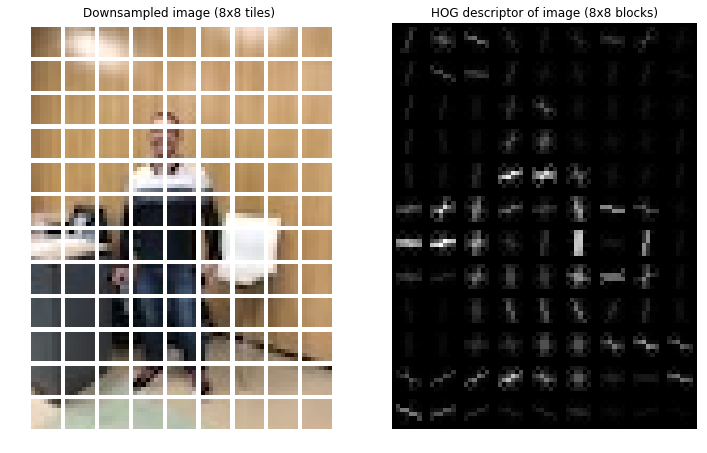

In [53]:
fd, hog_image = hog(jiahao, orientations=8, pixels_per_cell=(8, 8), cells_per_block=(1, 1), block_norm='L2-Hys', visualize=True)

# Custom (rgb) grid color
grid_color = [1,1,1]

# Modify the image to include the grid
jiahao[:,::8,:] = grid_color
jiahao[::8,:,:] = grid_color

plt.figure(figsize=(12,9))
plt.subplot(1,2,1)
plt.axis('off')
plt.title('Downsampled image (8x8 tiles)')
plt.imshow(jiahao)
plt.subplot(1,2,2)
plt.axis('off')
plt.title('HOG descriptor of image (8x8 blocks)')
plt.imshow(hog_image, cmap='gray')

fd.shape

## Dealing with data
### Loading images with corresponding labels & extracting features using HOG

In [3]:
def load_data():
    """
    Loads images
    
    returns:
        xs: set of RGB images [np array]
        ys: set of corresponding labels (-1: no person; 1: person) [np array]
    """
    posx = []
    for i in sorted(listdir('images/pos')):
        if i[0] != '.':
            img = cv2.imread('images/pos/{}'.format(i))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            posx.append(img)
    posy = np.ones((len(posx),))
    
    negx = []
    for i in sorted(listdir('images/neg')):
        if i[0] != '.':
            img = cv2.imread('images/neg/{}'.format(i))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            negx.append(img)
    negy = -np.ones((len(negx),))
    
    xs = np.array(posx + negx)
    ys = np.hstack((posy, negy))
    return xs, ys


def extract_features(xs, directions=8, block_size=8, show_progress=True):
    """
    Given a set of images, a set of their corresponding HOG descriptors are returned
    
    params:
        xs: set of RGB images [np array]
        directions: number of orientation directions to consider (default: 8) [integer]
        block_size: number of pixels in each image block (default: 12) [integer]
    returns:
        features: set with corresponding HOG features for each image [np array]
        hog_imgs: set with corresponding HOG image representations [np array]
    """
    features = []; hog_imgs = []
    progress = 0
    for i in xs:
        fd, hi = hog(i, orientations=directions, pixels_per_cell=(block_size, block_size), cells_per_block=(1, 1), visualize=True, block_norm='L2-Hys')
        features.append(fd)
        hog_imgs.append(hi)
        progress += 1
        if progress % 150 == 0:
            print('{} images completed'.format(progress))
        
    return np.array(features), np.array(hog_imgs)

In [4]:
x, y = load_data()

In [5]:
f, h = extract_features(x)

150 images completed
300 images completed
450 images completed
600 images completed
750 images completed
900 images completed
1050 images completed
1200 images completed
1350 images completed
1500 images completed
1650 images completed
1800 images completed
1950 images completed
2100 images completed
2250 images completed
2400 images completed
2550 images completed


(2582, 864) (2582,)


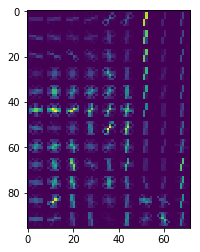

In [71]:
plt.imshow(h[850])
print(f.shape, y.shape)

### Shuffling data for random sampling

In [59]:
images, labels = shuffle(x, y, random_state=3)

The images and correspoinding labels are shuffled above.

Below, the first 100 samples are selected and displayed with their labels. It is evident that this shuffling is useful for mixing the positive and negative samples.

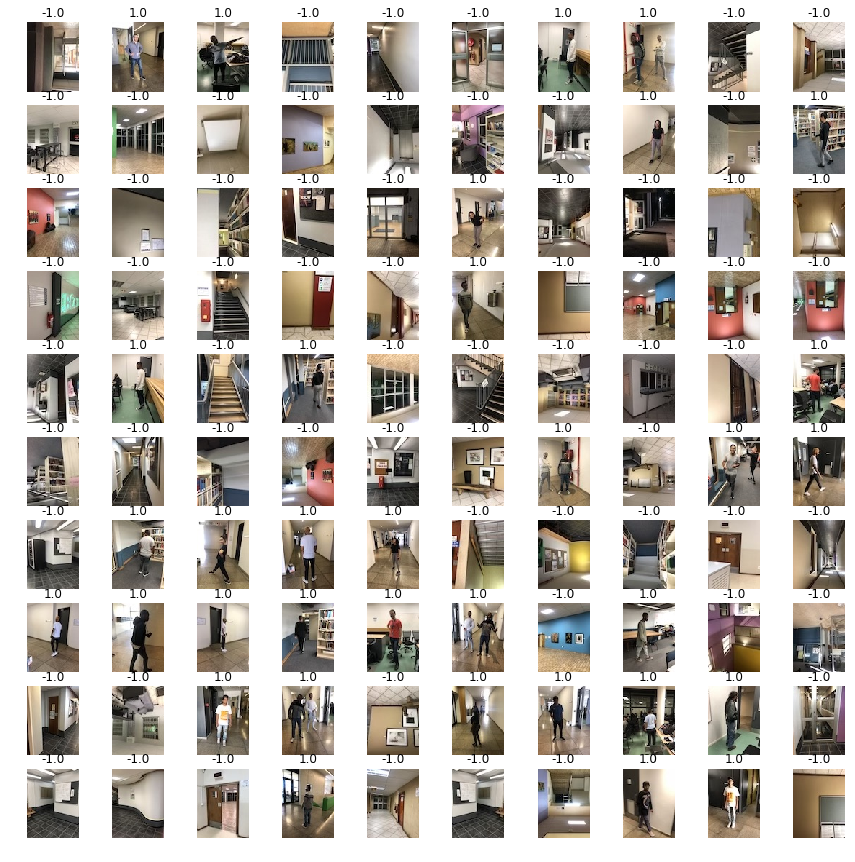

In [60]:
plt.figure(figsize=(15,15))
for x_,y_, i in zip(images[:100], labels[:100], np.arange(100)):
    plt.subplot(10,10,i+1)
    plt.imshow(x_)
    plt.title(y_)
    plt.axis('off')

### Splitting data into training & testing sets

In [10]:
def split_data(data, labels, train_split=0.75):
    """
    Split the data and labels into train and test sets
    
    params:
        data: all data [np array]
        labels: corresponding labels [np array]
        train_split: proportion of full dataset to be used for training [number between 0.5 and 1 inclusive]
    returns:
        x_train: training set data [np array]
        y_train: corresponding labels for training set [np array]
        x_test: testing set data [np array]
        y_test: corresponding labels for testing set [np array]
    """
    n = data.shape[0]
    s = int(train_split * n)
    
    x_train = data[:s]
    y_train = labels[:s]
    x_test = data[s+1:]
    y_test = labels[s+1:]
    
    return x_train, y_train, x_test, y_test

def shuffle_and_split(f, y, seed=None, train_split=0.75):
    data, labels = shuffle(f, y, random_state=seed)
    return split_data(data, labels, train_split)

In [11]:
x_train, y_train, x_test, y_test = shuffle_and_split(f, y, seed=0)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(1936, 864) (1936,) (645, 864) (645,)


## Support Vector Machine with linear kernel
Below is an implementation of a linear SVM. The model is intended for binary classification.

Quadratic programming is used to solve the optimisation problem formulated as:
$$\begin{equation}
\begin{split}
\min Q(\mathbf{w})&=\frac{1}{2} ||\mathbf{w}||^2\\
\mathrm{w.r.t } & \quad y_i(\mathbf{w}^T\mathbf{x}_i + b) \geq 1,\\
\end{split}
\end{equation}$$

Much of this model was based on [this SVM Example](https://github.com/cperales/SupportVectorMachine).

In [7]:
class Linear_SVM:
    """Implementation of Support Vector Machine with a linear kernel"""
    def __init__(self):
        self.x = None
        self.y = None
        self.w = None
        self.b = None
        
        
    def fit_soft(self, x, y, progress=True):
        """
        Fit alphas for dual problem soft margin SVM.
        
        params:
            numpy.array x: instances.
            param numpy.array y: labels.
        
        returns:
            alphas: 
        """
        num = x.shape[0]
        dim = x.shape[1]
        C = 1.0 / dim  # Penalty
        
        K = y[:, None] * x
        K = np.dot(K, K.T)
        P = matrix(K)
        q = matrix(-np.ones((num, 1)))
        g = np.concatenate((-np.eye(num), np.eye(num)))
        G = matrix(g)
        h_array = np.concatenate((np.zeros(num), C * np.ones(num)))
        h = matrix(h_array)
        A = matrix(y.reshape(1, -1))
        b = matrix(np.zeros(1))
        
        solvers.options['show_progress'] = progress
        sol = solvers.qp(P, q, G, h, A, b)
        
        alphas = np.array(sol['x'])
        return alphas
        
        
    def fit_hard(self, x, y, progress=True):
        """
        Fit alphas for dual problem soft margin SVM.
        
        params:
            numpy.array x: instances.
            param numpy.array y: labels.
        
        returns:
            alphas: 
        """
        num = x.shape[0]
        dim = x.shape[1]
        # obtain the kernel
        K = y[:, None] * x
        K = np.dot(K, K.T)
        P = matrix(K)
        q = matrix(-np.ones((num, 1)))
        G = matrix(-np.eye(num))
        h = matrix(np.zeros(num))
        A = matrix(y.reshape(1, -1))
        b = matrix(np.zeros(1))
        solvers.options['show_progress'] = progress
        sol = solvers.qp(P, q, G, h, A, b)
        alphas = np.array(sol['x'])
        return alphas

    
    def fit(self, x, y, soft=True, progress=True):
        """
        Fit the model according to the given training data.
        
        parameters:
            x: numpy.array 
            y: numpy.array
        """
        if soft:
            alphas = self.fit_soft(x, y, progress)
        else:
            alphas = self.fit_hard(x, y, progress)

        # get weights
        w = np.sum(alphas * y[:, None] * x, axis=0)
        # get b
        b_vector = y - np.dot(x, w)
        b = b_vector.sum() / b_vector.size

        # normalize
        norm = np.linalg.norm(w)
        w, b = w / norm, b / norm

        # Store values
        self.w = w
        self.b = b
        
        
    def predict(self, X):
        """
        Predicts label for given features
        
        params:
            X: features
        returns:
            y: label (-1 or 1)
        """
        y = np.sign(np.dot(self.w, X.T) + self.b * np.ones(X.shape[0]))
        return y

### Fit SVM on training data

In [12]:
svm = Linear_SVM()
svm.fit(x_train, y_train, progress=True)

     pcost       dcost       gap    pres   dres
 0: -1.6743e+02 -1.1926e+01  1e+04  1e+02  7e-13
 1: -1.5732e+01 -8.7379e+00  6e+02  5e+00  7e-13
 2: -3.0569e+00 -5.3805e+00  5e+01  4e-01  7e-14
 3: -1.1627e+00 -4.4673e+00  4e+00  8e-03  8e-15
 4: -1.1898e+00 -1.8031e+00  7e-01  1e-03  3e-15
 5: -1.2933e+00 -1.4467e+00  2e-01  2e-04  3e-15
 6: -1.3323e+00 -1.3789e+00  5e-02  4e-05  3e-15
 7: -1.3471e+00 -1.3560e+00  9e-03  5e-06  3e-15
 8: -1.3504e+00 -1.3515e+00  1e-03  4e-07  3e-15
 9: -1.3509e+00 -1.3509e+00  8e-05  3e-08  3e-15
10: -1.3509e+00 -1.3509e+00  2e-06  6e-10  3e-15
11: -1.3509e+00 -1.3509e+00  4e-08  1e-11  4e-15
Optimal solution found.


### Predictions and performance on test set

In [151]:
def run(f, y, soft=True, progress=True):
    """
    trains svm on random training split and classifies test set
    
    param:
        f: set of HOG descriptors [np array]
        y: corresponding labels for HOG descriptors [np array]
    returns:
        y_test: class labels of test set [np array]
        y_pred: predicted values for test set using trained SVM [np array]
    """
    x_train, y_train, x_test, y_test = shuffle_and_split(f, y)
    svm = Linear_SVM()
    svm.fit(x_train, y_train, soft=soft, progress=progress)
    y_pred = np.array([svm.predict(x)[0] for x in x_test])
    return y_test, y_pred


def run_trials(f, y, ntrials=25, soft=True):
    accuracies = np.zeros(ntrials)
    precisions = np.zeros(ntrials)
    recalls = np.zeros(ntrials)
    
    for i in np.arange(ntrials):
        y_test, y_pred = run(f, y, progress=False, soft=soft)
        accuracies[i] = accuracy_score(y_test, y_pred)
        precisions[i] = precision_score(y_test, y_pred)
        recalls[i] = recall_score(y_test, y_pred)
        print('Experiments completed: {}'.format(i+1))
    
    return accuracies, precisions, recalls

In [149]:
y_test, y_pred = run(f, y, progress=True)
print(confusion_matrix(y_test, y_pred))
accuracy_score(y_test, y_pred)

     pcost       dcost       gap    pres   dres
 0: -1.6545e+02 -1.1401e+01  1e+04  1e+02  4e-13
 1: -1.4605e+01 -8.3956e+00  5e+02  5e+00  6e-13
 2: -3.0221e+00 -5.2363e+00  5e+01  4e-01  5e-14
 3: -1.1603e+00 -4.3573e+00  4e+00  1e-02  7e-15
 4: -1.1770e+00 -1.7641e+00  6e-01  1e-03  4e-15
 5: -1.2754e+00 -1.4343e+00  2e-01  2e-04  4e-15
 6: -1.3172e+00 -1.3581e+00  4e-02  3e-05  4e-15
 7: -1.3289e+00 -1.3401e+00  1e-02  5e-06  4e-15
 8: -1.3332e+00 -1.3342e+00  1e-03  3e-07  5e-15
 9: -1.3337e+00 -1.3337e+00  3e-05  7e-09  5e-15
10: -1.3337e+00 -1.3337e+00  1e-06  2e-10  4e-15
Optimal solution found.
[[344  45]
 [ 32 224]]


0.8806201550387597

In [184]:
accuracy, precision, recall = run_trials(f,y,25)

Experiments completed: 1
Experiments completed: 2
Experiments completed: 3
Experiments completed: 4
Experiments completed: 5
Experiments completed: 6
Experiments completed: 7
Experiments completed: 8
Experiments completed: 9
Experiments completed: 10
Experiments completed: 11
Experiments completed: 12
Experiments completed: 13
Experiments completed: 14
Experiments completed: 15
Experiments completed: 16
Experiments completed: 17
Experiments completed: 18
Experiments completed: 19
Experiments completed: 20
Experiments completed: 21
Experiments completed: 22
Experiments completed: 23
Experiments completed: 24
Experiments completed: 25


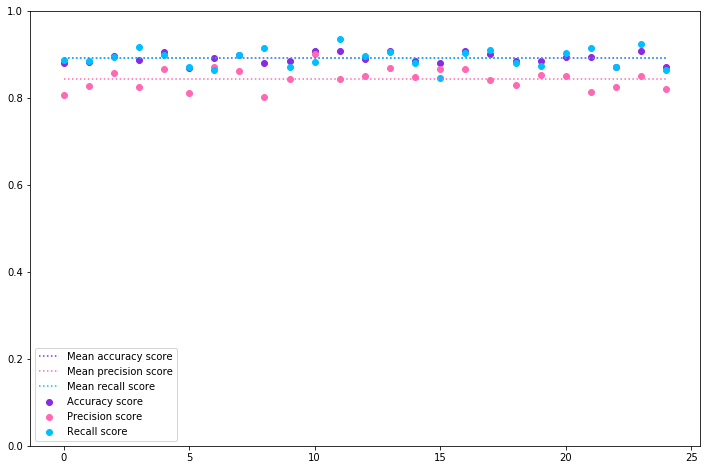

In [194]:
trial_range = np.arange(25)

plt.figure(figsize=(12,8))
axes = plt.gca()
axes.set_ylim([0,1])

plt.scatter(trial_range, accuracy, label='Accuracy score', color = 'blueviolet')
plt.plot(trial_range, np.full(25, np.mean(accuracy)), label='Mean accuracy score', linestyle='dotted', color='blueviolet')
plt.scatter(trial_range, precision, label='Precision score', color='hotpink')
plt.plot(trial_range, np.full(25, np.mean(precision)), label='Mean precision score', linestyle='dotted', color='hotpink')
plt.scatter(trial_range, recall, label='Recall score', color='deepskyblue')
plt.plot(trial_range, np.full(25, np.mean(recall)), label='Mean recall score', linestyle='dotted', color='deepskyblue')
plt.legend()

In [219]:
print('{:10s} {:10s} {:10s} {:10s}'.format('','Mean', 'Minimum', 'Maximum'))
print('{:10s} {:<10.3f} {:<10.3f} {:<10.3f}'.format('Accuracy', np.mean(accuracy), np.min(accuracy), np.max(accuracy)))
print('{:10s} {:<10.3f} {:<10.3f} {:<10.3f}'.format('Precision', np.mean(precision), np.min(precision), np.max(precision)))
print('{:10s} {:<10.3f} {:<10.3f} {:<10.3f}'.format('Recall', np.mean(recall), np.min(recall), np.max(recall)))

           Mean       Minimum    Maximum   
Accuracy   0.891      0.868      0.909     
Precision  0.844      0.803      0.900     
Recall     0.891      0.845      0.936     


In [187]:
accuracy_soft, precision_soft, recall_soft = run_trials(f,y,25, soft=False)

Experiments completed: 1
Experiments completed: 2
Experiments completed: 3
Experiments completed: 4
Experiments completed: 5
Experiments completed: 6
Experiments completed: 7
Experiments completed: 8
Experiments completed: 9
Experiments completed: 10
Experiments completed: 11
Experiments completed: 12
Experiments completed: 13
Experiments completed: 14
Experiments completed: 15
Experiments completed: 16
Experiments completed: 17
Experiments completed: 18
Experiments completed: 19
Experiments completed: 20
Experiments completed: 21
Experiments completed: 22
Experiments completed: 23
Experiments completed: 24
Experiments completed: 25


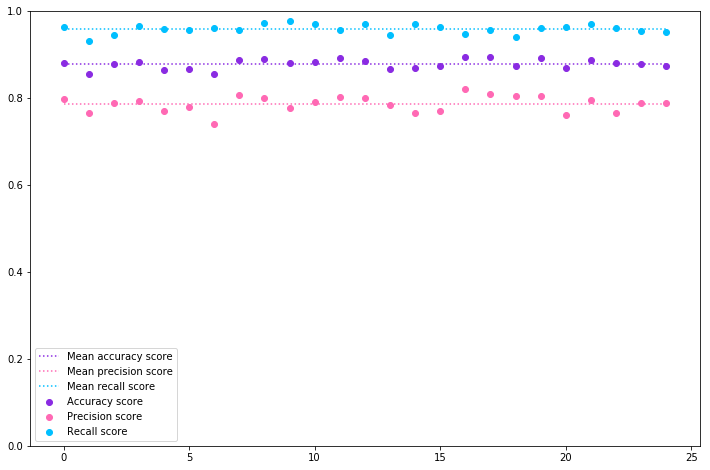

In [195]:
trial_range = np.arange(25)

plt.figure(figsize=(12,8))
axes = plt.gca()
axes.set_ylim([0,1])

plt.scatter(trial_range, accuracy_soft, label='Accuracy score', color = 'blueviolet')
plt.plot(trial_range, np.full(25, np.mean(accuracy_soft)), label='Mean accuracy score', linestyle='dotted', color='blueviolet')
plt.scatter(trial_range, precision_soft, label='Precision score', color='hotpink')
plt.plot(trial_range, np.full(25, np.mean(precision_soft)), label='Mean precision score', linestyle='dotted', color='hotpink')
plt.scatter(trial_range, recall_soft, label='Recall score', color='deepskyblue')
plt.plot(trial_range, np.full(25, np.mean(recall_soft)), label='Mean recall score', linestyle='dotted', color='deepskyblue')
plt.legend()

In [218]:
print('{:10s} {:10s} {:10s} {:10s}'.format('','Mean', 'Minimum', 'Maximum'))
print('{:10s} {:<10.3f} {:<10.3f} {:<10.3f}'.format('Accuracy', np.mean(accuracy_soft), np.min(accuracy_soft), np.max(accuracy_soft)))
print('{:10s} {:<10.3f} {:<10.3f} {:<10.3f}'.format('Precision', np.mean(precision_soft), np.min(precision_soft), np.max(precision_soft)))
print('{:10s} {:<10.3f} {:<10.3f} {:<10.3f}'.format('Recall', np.mean(recall_soft), np.min(recall_soft), np.max(recall_soft)))

           Mean       Minimum    Maximum   
Accuracy   0.878      0.854      0.895     
Precision  0.787      0.741      0.821     
Recall     0.959      0.932      0.976     


### Demo (requires webcam)

In [ ]:
output_notebook()

cap = cv2.VideoCapture(0)
ret, frame = cap.read()

frame=cv2.cvtColor(frame, cv2.COLOR_BGR2RGBA)
frame=cv2.flip(frame, -1) # flip vertically
frame = frame[:,244:604]
width=frame.shape[1]
height=frame.shape[0]

p = figure(title="Person detection", x_range=(0,width), y_range=(0,height), output_backend="webgl", width=width, height=height)
p.title.align = "center"
p.title.text_font_size = "20px"
myImage = p.image_rgba(image=[frame], x=0, y=0, dw=width, dh=height)
show(p, notebook_handle=True)

resized = cv2.resize(frame, (72,96), interpolation = cv2.INTER_AREA)
resized = cv2.cvtColor(resized, cv2.COLOR_RGBA2RGB)
resized = cv2.flip(resized, -1)
hog_frame = hog(resized, orientations=8, pixels_per_cell=(8, 8), cells_per_block=(1, 1), block_norm='L2-Hys')

while True:
    ret, frame = cap.read()
    frame=cv2.cvtColor(frame, cv2.COLOR_BGR2RGBA)
    frame=cv2.flip(frame, -1)
    frame = frame[:,244:604]
    
    resized = cv2.resize(frame, (72,96), interpolation = cv2.INTER_LINEAR)
    resized = cv2.cvtColor(resized, cv2.COLOR_RGBA2RGB)
    resized = cv2.flip(resized, -1)
    hog_frame = hog(resized, orientations=8, pixels_per_cell=(8, 8), cells_per_block=(1, 1), block_norm='L2-Hys')
    
    if svm.predict(hog_frame)[0] == 1:
        p.title.text = "I see someone..."
        p.title.text_color = "green"
    else:
        p.title.text = "Nobody's there..."
        p.title.text_color = "red"
    
    myImage.data_source.data['image']=[frame]
    push_notebook()
    time.sleep(0.5)